# Engenharia de Machine Learning [25E1_3]
## Data 26/03/2025


## Import das bibliotecas

In [14]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, roc_curve, auc
from sklearn.svm import SVC

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw

from scipy.signal import correlate

# Carregando os dados

In [35]:
df = catalog.load('data_raw')
df_filtered = catalog.load('data_filtered')

[03/27/25 19:55:05] INFO     Loading data from data_raw (CSVDataSet)...                         ]8;id=823116;file:///home/zeta/miniconda3/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=945140;file:///home/zeta/miniconda3/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py#401\401]8;;\

                    INFO     Loading data from data_filtered (ParquetDataSet)...                ]8;id=739521;file:///home/zeta/miniconda3/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=696078;file:///home/zeta/miniconda3/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py#401\401]8;;\

### Criando as varáveis

In [16]:
# todos os campos 
features_all = ['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs', 'season', 'seconds_remaining', 'shot_distance', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id']
features =  ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']
target = ['shot_made_flag']

## Analisando os dados

### Visualizando algumas informações do Dataset

In [17]:
# Verificando campos nulos
df.isna().sum()


action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
shot_id                  0
dtype: int64

In [18]:
# Tamanho do dataset antes de remover os nulos
df.shape

(30697, 25)

In [37]:
# Removendo os campos nulos
df = df.dropna()
# Agora deve mostrar que não há mais campos nulos
df.isna().sum()
print("Comparando base raw limpa no Jupiter (aqui ainda tem todos os campos) e base do Kedro")
print("Jupyter:", df.shape)
print("Kedro..:", df_filtered.shape)

Comparando base raw limpa no Jupiter (aqui ainda tem todos os campos) e base do Kedro
Jupyter: (25697, 25)
Kedro..: (25697, 7)


In [39]:
# Mostra as primeiras linhas do dataset
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


In [40]:
# Mostrando as estatísticas descritivas para entender a faixa dinâmica das variáveis
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000
mean,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
std,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000
25%,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000
50%,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
75%,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000
max,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


## Criando as bases X e y

In [44]:
# Normalização dos dados para a clusterização
X = df[features]
# Target (predição)
y = df[target]

print("Comparando base raw limpa aqui e base limpa no Kedro")
print("Jupyter:", X.shape, "--> Aqui a variável shot_made_flag foi removida")
print("Kedro..:", df_filtered.shape)

Comparando base raw limpa aqui e base limpa no Kedro
Jupyter: (25697, 6) --> Aqui a variável shot_made_flag foi removida
Kedro..: (25697, 7)


## Criando as bases de dados de treino e teste

In [45]:
# Configurando 80% de treino e 20% para teste
test_size = 0.2

# Random state
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

# Reconstruindo os DataFrames completos
train_df_jupyter = pd.concat([X_train, y_train], axis=1)
test_df_jupyter = pd.concat([X_test, y_test], axis=1)

## Carregando a base de treino e teste do Kedro

In [46]:
train_df = catalog.load('base_train')
test_df = catalog.load('base_test')

[03/27/25 20:00:21] INFO     Loading data from base_train (ParquetDataSet)...                   ]8;id=408574;file:///home/zeta/miniconda3/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=138332;file:///home/zeta/miniconda3/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py#401\401]8;;\

                    INFO     Loading data from base_test (ParquetDataSet)...                    ]8;id=404845;file:///home/zeta/miniconda3/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=684784;file:///home/zeta/miniconda3/envs/kedro/lib/python3.10/site-packages/kedro/io/data_catalog.py#401\401]8;;\

In [48]:
# comparando o processo feito aqui com o processo feito no Kedro
print("Jupyter:", (train_df_jupyter.shape, test_df_jupyter.shape))
print("Kedro..:", (train_df.shape, test_df.shape))

Jupyter: ((20557, 7), (5140, 7))
Kedro..: ((20557, 7), (5140, 7))


### Análise Exploratória

#### Histograma com todas as variáveis

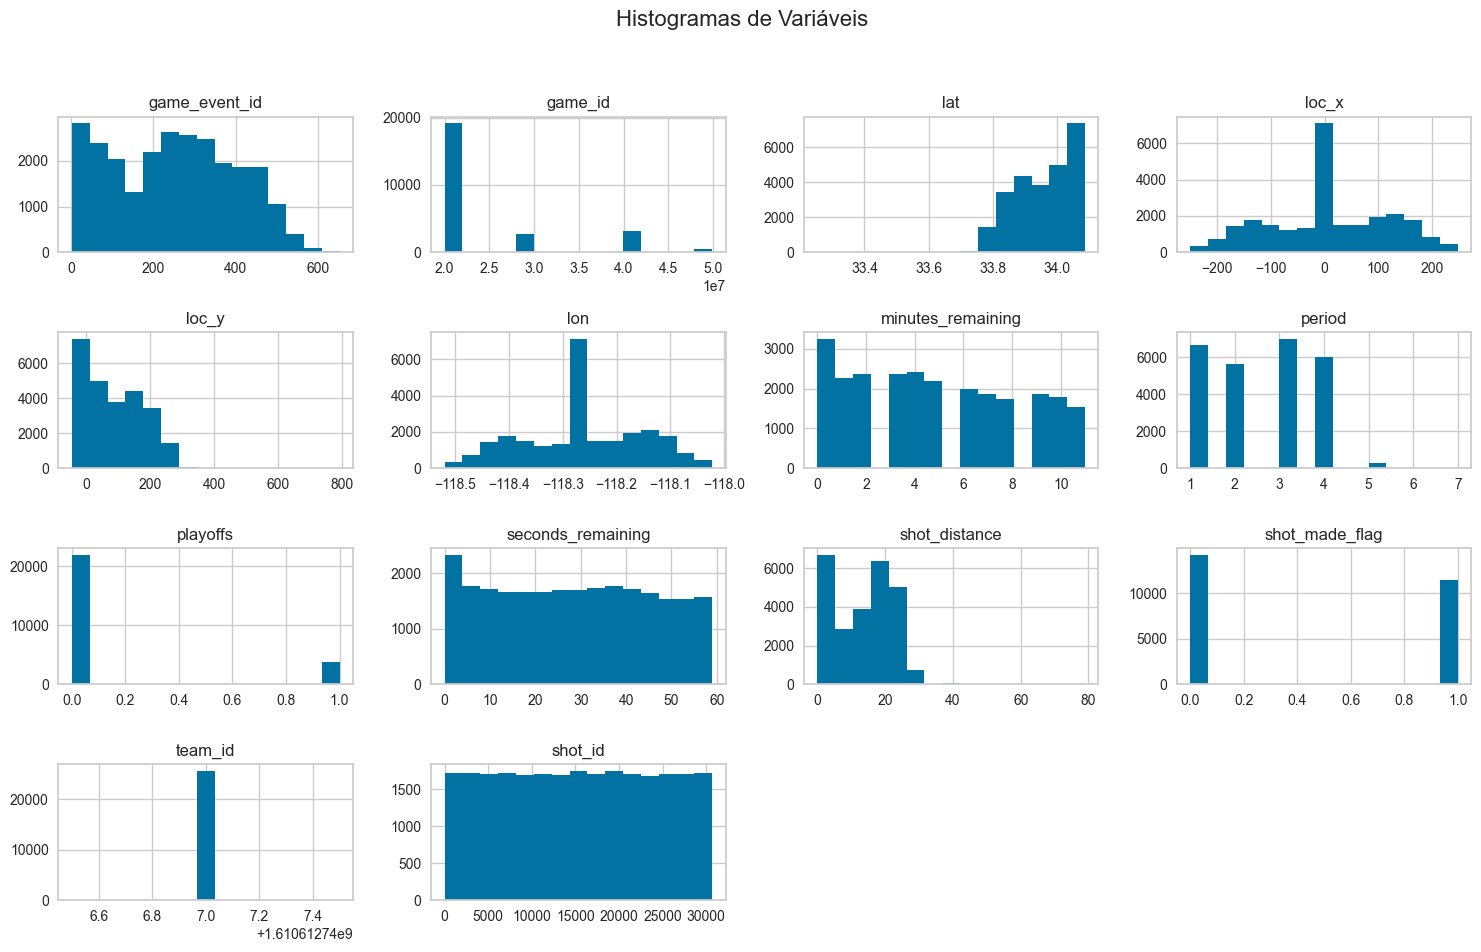

In [49]:
# Visualizando as variáveis de interesse
df.hist(bins=15, figsize=(15, 10))
plt.suptitle('Histogramas de Variáveis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Histograma das variáveis de interesse

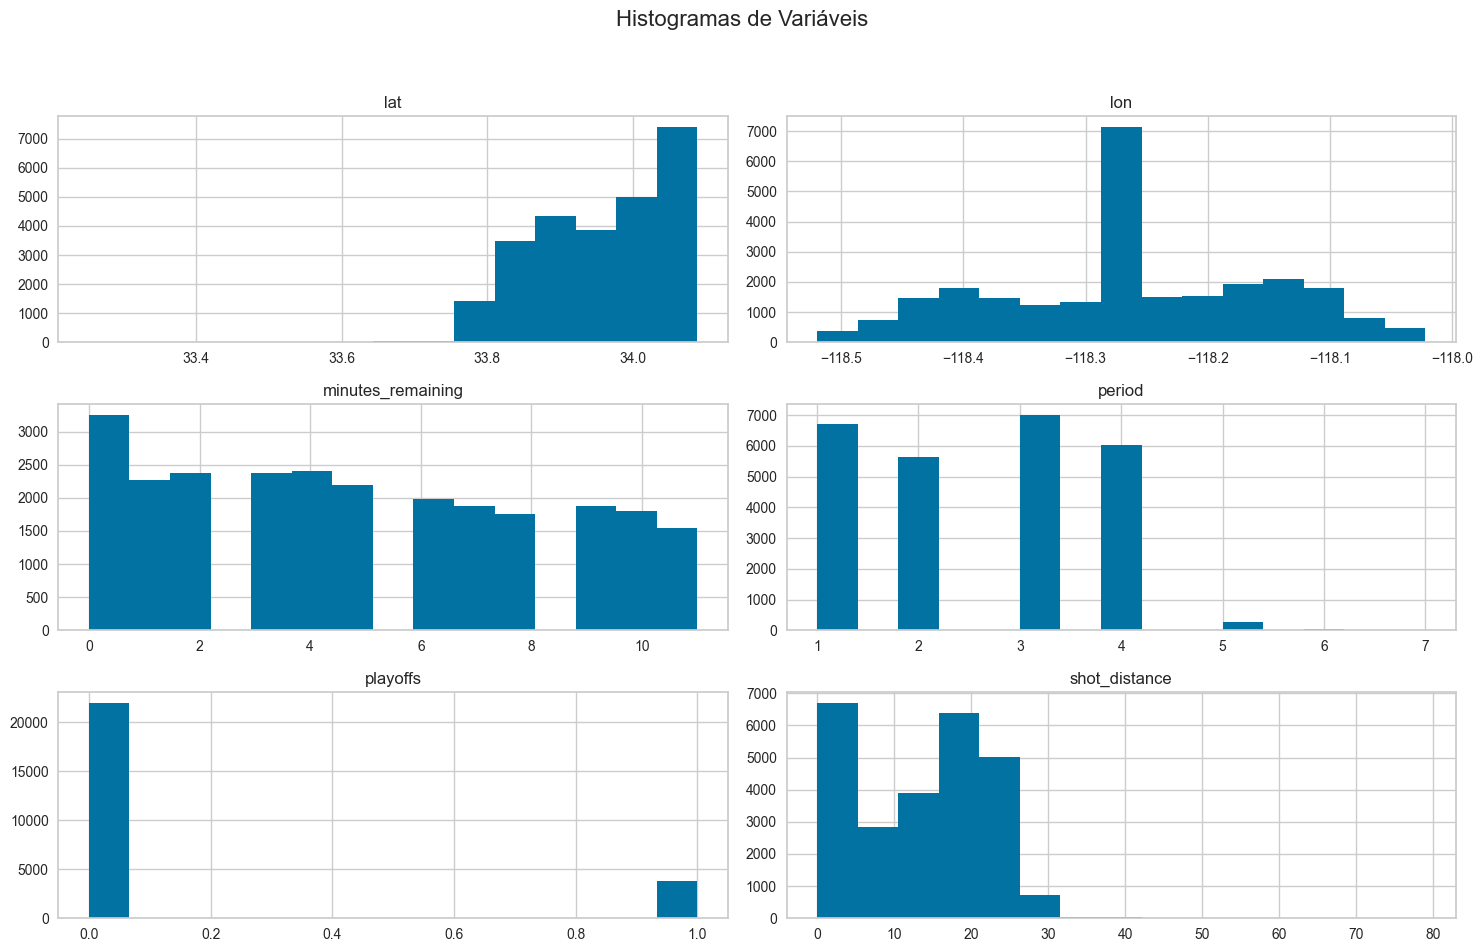

In [50]:
# Visualizando as variáveis de interesse
X.hist(bins=15, figsize=(15, 10))
plt.suptitle('Histogramas de Variáveis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Por: `Eder Martins`

## Obrigado!